# Download Dataset

In [ ]:
!curl -L -o ./dataset.zip\
https://www.kaggle.com/api/v1/datasets/download/samuelcortinhas/muffin-vs-chihuahua-image-classification

SyntaxError: invalid syntax (1033580897.py, line 1)

In [ ]:
import zipfile
with zipfile.ZipFile('./dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

# Import-import

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Preparation

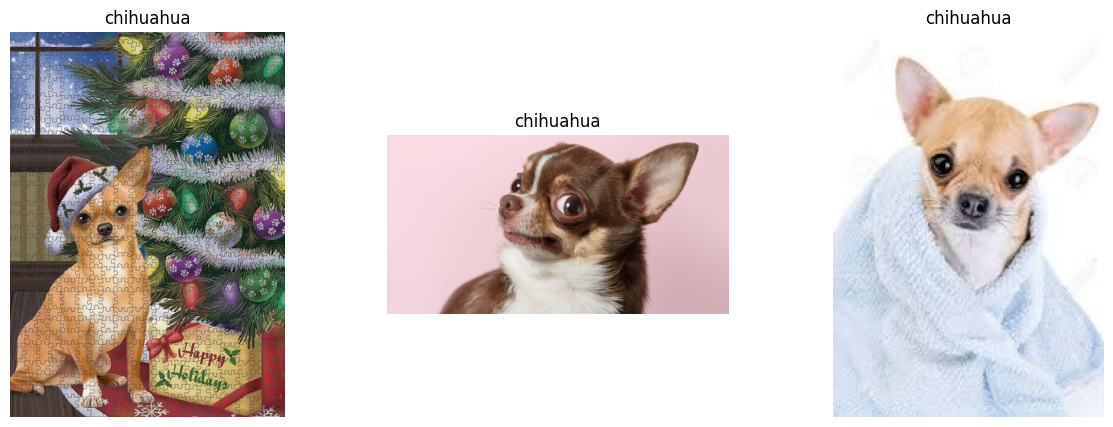

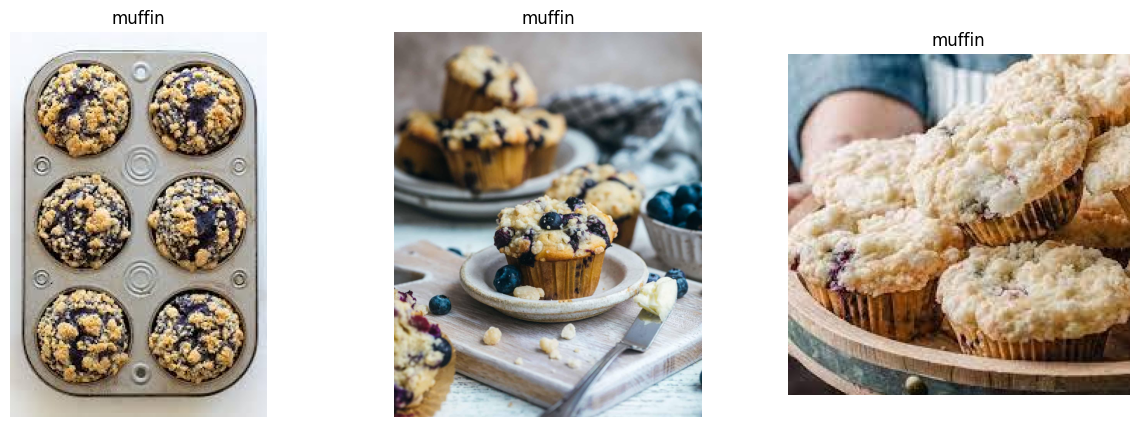

In [18]:
train_dir = './dataset/train'
test_dir = './dataset/test'

def display_gambar(directory, num_images=3):
    classes = os.listdir(directory)
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        images = np.random.choice(os.listdir(class_dir), num_images, replace=False)
        plt.figure(figsize=(15, 5))
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
        plt.show()

display_gambar(train_dir, num_images=3)

Info lebih lanjut tentang `ImageDataGenerator` dapat diakses pada link berikut:
- [Dokumentasi](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [Contoh Implementasi](https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/)

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 90,
                                    horizontal_flip = True,
                                    brightness_range = [0.5,1.0])
test_datagen = ImageDataGenerator(rescale = 1./255)

In [36]:
image_sizee = 128
image_channell = 3
batch_sizee = 64

In [37]:
train_data = train_datagen.flow_from_directory(train_dir,  
                                         target_size=(image_sizee, image_sizee), 
                                         batch_size=batch_sizee, 
                                         class_mode='sparse', 
                                         shuffle=True)  
test_data = test_datagen.flow_from_directory(test_dir, 
                                        target_size=(image_sizee, image_sizee), 
                                        batch_size=batch_sizee, 
                                        class_mode='sparse', 
                                        shuffle=True)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [38]:
print(f'Train data shape: {train_data.image_shape}')
print(f'Test data shape: {test_data.image_shape}')

Train data shape: (128, 128, 3)
Test data shape: (128, 128, 3)


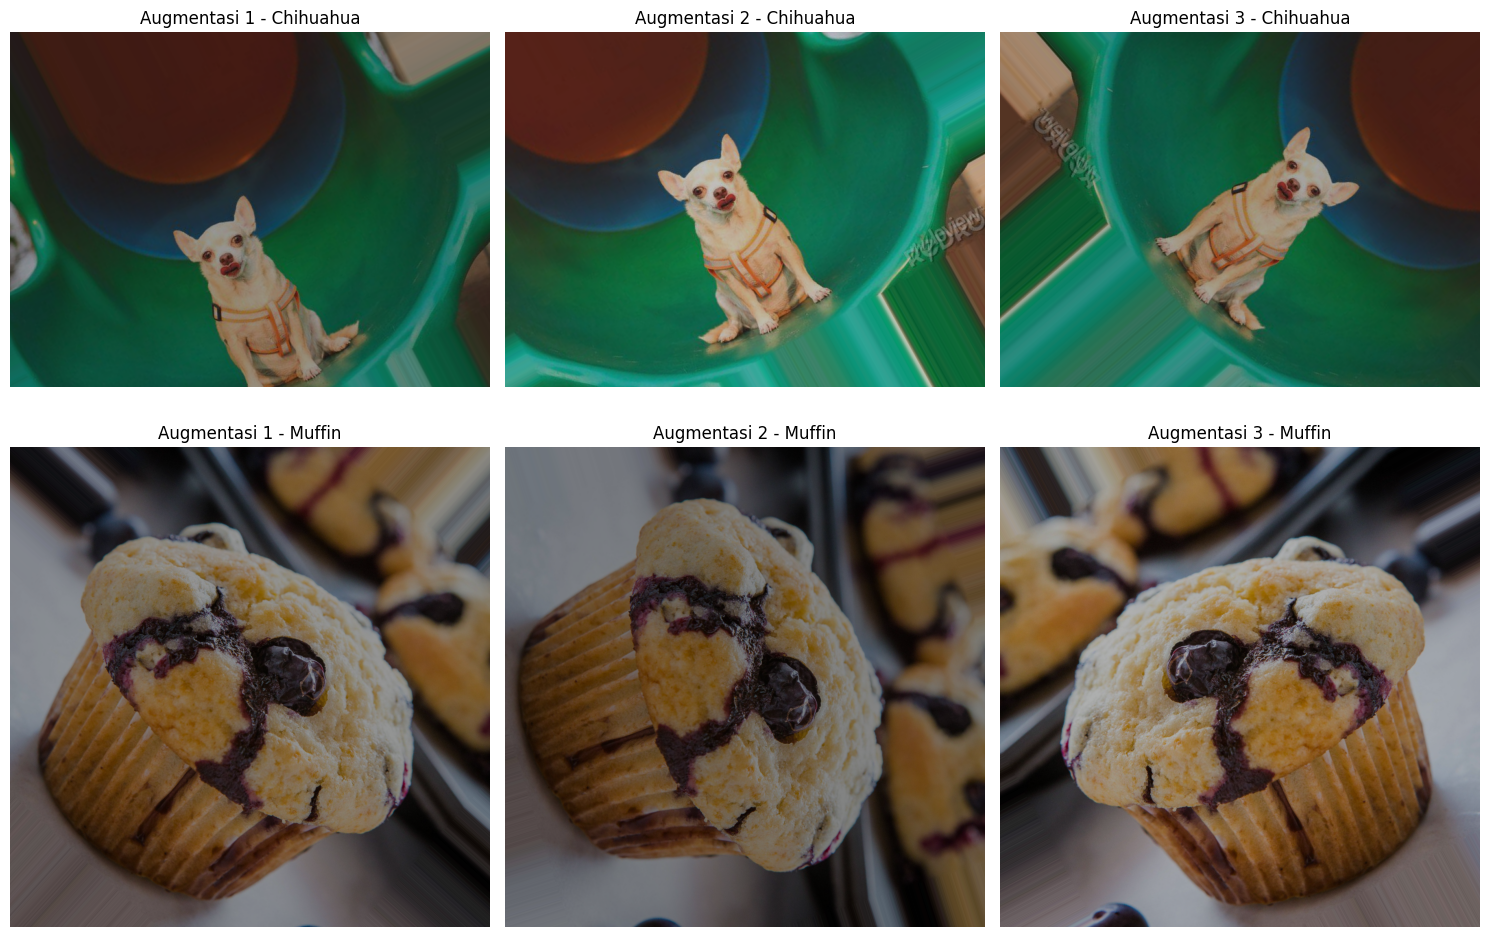

In [39]:
img_path = './dataset/train/chihuahua/img_4_972.jpg'
img = load_img(img_path)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_path_2 = './dataset/train/muffin/img_0_385.jpg'
img_2 = load_img(img_path_2)
img_array_2 = img_to_array(img_2)
img_array_2 = np.expand_dims(img_array_2, axis=0)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, batch in enumerate(train_datagen.flow(img_array, batch_size=1)):
    if i == 3: 
        break
    augmented_img = batch[0]
    axes[0, i].imshow(augmented_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Augmentasi {i+1} - Chihuahua')

for i, batch in enumerate(train_datagen.flow(img_array_2, batch_size=1)):
    if i == 3:
        break
    augmented_img = batch[0]
    axes[1, i].imshow(augmented_img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Augmentasi {i+1} - Muffin')

plt.tight_layout()
plt.show()

# Mengatur Callback + Visualisasi Grafik Train-Validation

In [40]:
checkpoint_path = 'training_model/cp.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, verbose=1, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

In [41]:
def display_metrik(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

# Cek Menggunakan GPU atau tidak

In [42]:
print("Available devices:")
print(tensorflow.config.list_physical_devices())

if tensorflow.test.is_gpu_available():
    print("Training menggunakan GPU!")
else:
    print("Training menggunakan CPU.")

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training menggunakan GPU!


# Model 1
## Flatten + Dense

In [43]:
def model_1():
    model = Sequential()
    model.add(Flatten (input_shape=[image_sizee,image_sizee,image_channell]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics = ['accuracy'])
    return model

model_pertama = model_1()
model_pertama.summary()

Model: "sequential_3"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                3145792   
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3,147,905
Trainable params: 3,147,905
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_pertama = model_pertama.fit(train_data,
                                    epochs=30,
                                    validation_data=test_data,
                                    verbose=1,
                                    callbacks=[cp_callback, lr_reduce, early_stopping], 
                                    batch_size=batch_sizee)
test_loss, test_acc = model_pertama.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/30
74/74 [==============================] - 29s 391ms/step - loss: 2.1775 - accuracy: 0.4593 - val_loss: 1.2363 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - 31s 413ms/step - loss: 0.6726 - accuracy: 0.4593 - val_loss: 0.5687 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - 27s 366ms/step - loss: 0.6551 - accuracy: 0.4593 - val_loss: 0.6277 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 4/30
74/74 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.4593
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
74/74 [==============================] - 29s 390ms/step - loss: 0.7048 - accuracy: 0.4593 - val_loss: 0.5825 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 5/30
74/74 [==============================] - 28s 377ms/step - loss: 0.5753 - accuracy: 0.4593 - val_loss: 0.5848 - val_accuracy: 0.4595 - lr: 3.0000e-04
Epoch 6/30
74/74 [==============================] - 28s 3

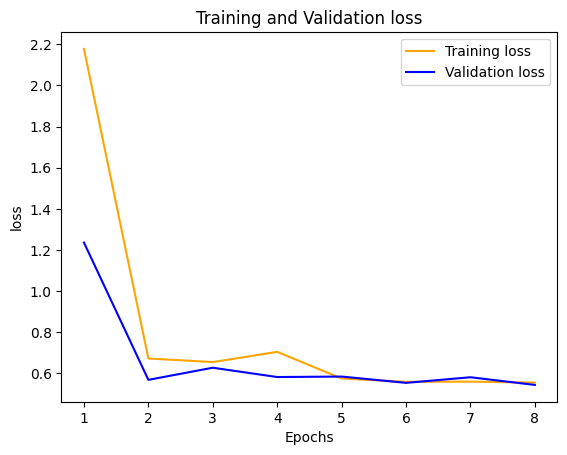

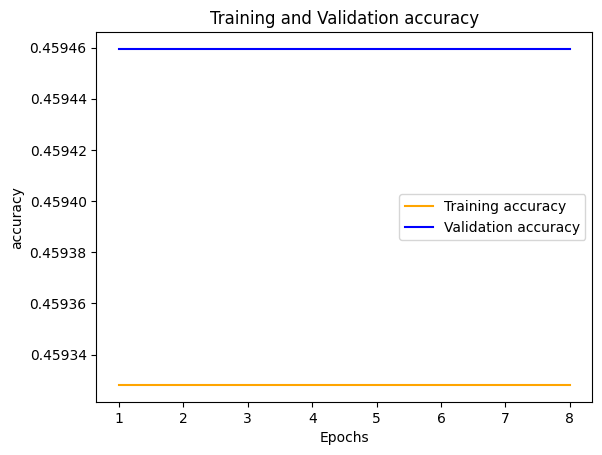

In [45]:
display_metrik(history_pertama, 'loss')
display_metrik(history_pertama, 'accuracy')

# Model 2
## Ditambahin BatcNormalization

In [46]:
def model_2():
    model = Sequential()
    model.add(Flatten (input_shape=[image_sizee,image_sizee,image_channell]))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    return model
model_kedua = model_2()
model_kedua.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 49152)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6291584   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 32)               

In [47]:
history_kedua = model_kedua.fit(train_data,
                                epochs=30,
                                validation_data=test_data,
                                verbose=1,
                                callbacks=[cp_callback, lr_reduce, early_stopping], 
                                batch_size=batch_sizee)
test_loss, test_acc = model_kedua.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/30
74/74 [==============================] - 31s 415ms/step - loss: 0.6348 - accuracy: 0.6598 - val_loss: 0.6975 - val_accuracy: 0.5735 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - 28s 383ms/step - loss: 0.5749 - accuracy: 0.7118 - val_loss: 0.6362 - val_accuracy: 0.6318 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - 29s 394ms/step - loss: 0.5580 - accuracy: 0.7165 - val_loss: 0.6024 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 4/30
74/74 [==============================] - 30s 399ms/step - loss: 0.5438 - accuracy: 0.7332 - val_loss: 0.7412 - val_accuracy: 0.6123 - lr: 0.0010
Epoch 5/30
74/74 [==============================] - 29s 387ms/step - loss: 0.5364 - accuracy: 0.7340 - val_loss: 0.6798 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 6/30
74/74 [==============================] - 31s 419ms/step - loss: 0.5267 - accuracy: 0.7391 - val_loss: 0.5916 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 7/30
74/74 [==============================] - 33s 445ms/st

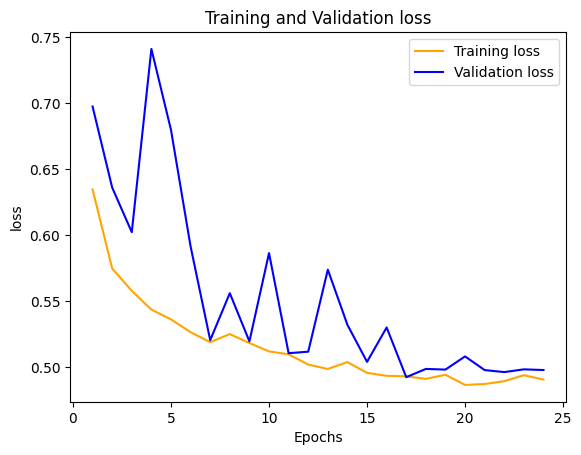

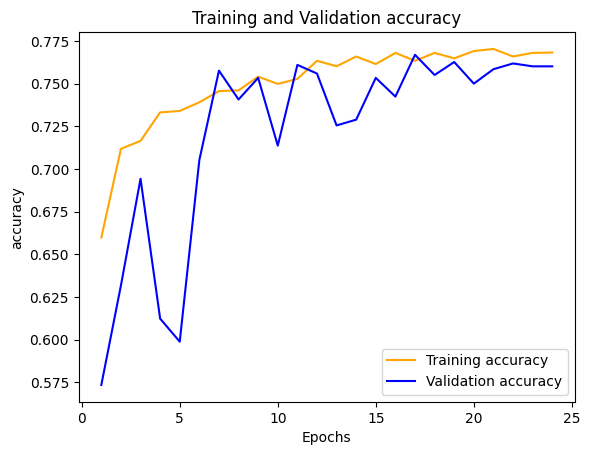

In [48]:
display_metrik(history_kedua, 'loss')
display_metrik(history_kedua, 'accuracy')

# Model 3
## Flatten + Dense (regularizers) + Dropout

In [49]:
def model_3():
    model= Sequential()
    model.add(Flatten(input_shape=[image_sizee,image_sizee,image_channell]))
    model.add(Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model_ketiga = model_3()
model_ketiga.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 49152)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               6291584   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)               

In [50]:
history_ketiga = model_ketiga.fit(train_data,
                                    epochs=30,
                                    validation_data=test_data,
                                    verbose=1,
                                    callbacks=[cp_callback, lr_reduce, early_stopping], 
                                    batch_size=batch_sizee)
test_loss, test_acc = model_ketiga.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/30
74/74 [==============================] - 37s 498ms/step - loss: 3.9318 - accuracy: 0.5181 - val_loss: 2.2092 - val_accuracy: 0.5659 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - 29s 389ms/step - loss: 1.8654 - accuracy: 0.5373 - val_loss: 1.6255 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - 29s 393ms/step - loss: 1.5235 - accuracy: 0.5187 - val_loss: 1.4226 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 4/30
74/74 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.5293
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
74/74 [==============================] - 28s 377ms/step - loss: 1.3994 - accuracy: 0.5293 - val_loss: 1.3724 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 5/30
74/74 [==============================] - 33s 448ms/step - loss: 1.3279 - accuracy: 0.5280 - val_loss: 1.3100 - val_accuracy: 0.4603 - lr: 3.0000e-04
Epoch 6/30
74/74 [==============================] - 33s 4

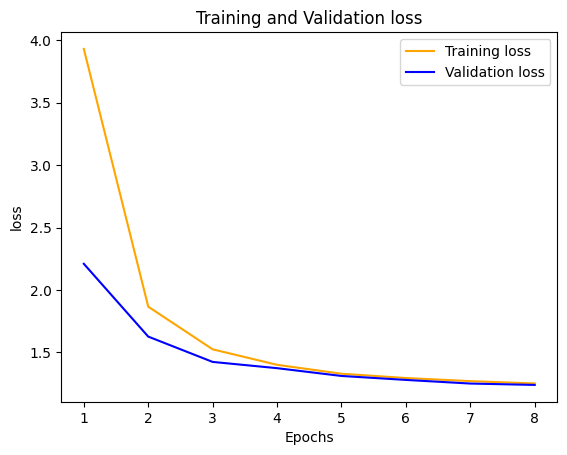

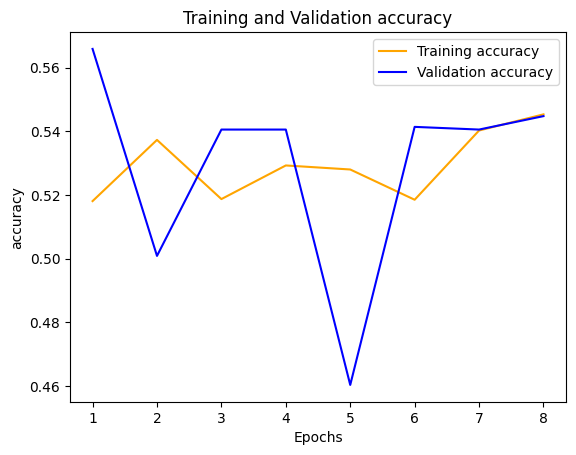

In [51]:
display_metrik(history_ketiga, 'loss')
display_metrik(history_ketiga, 'accuracy')

# Model 4 (CNN)
## Simple CNN

In [52]:
def model_4():
    model= Sequential()
    model.add(Conv2D(64, kernel_size=(2,2), activation='relu', input_shape=[image_sizee,image_sizee,image_channell]))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    return model
model_keempat = model_4()
model_keempat.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 flatten_6 (Flatten)         (None, 254016)            0         
                                                                 
 dense_21 (Dense)            (None, 32)                8128544   
                                                                 
 dense_22 (Dense)            (None, 2)                 66        
                                                                 
Total params: 8,129,442
Trainable params: 8,129,442
Non-trainable params: 0
____________________________________________

In [53]:
history_keempat = model_keempat.fit(train_data,
                                    epochs=30,
                                    validation_data=test_data,
                                    verbose=1,
                                    callbacks=[cp_callback, lr_reduce, early_stopping], 
                                    batch_size=batch_sizee)
test_loss, test_acc = model_keempat.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/30
74/74 [==============================] - 39s 442ms/step - loss: 2.8108 - accuracy: 0.6744 - val_loss: 0.5189 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - 30s 402ms/step - loss: 0.4444 - accuracy: 0.8041 - val_loss: 0.4173 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - 29s 395ms/step - loss: 0.3993 - accuracy: 0.8234 - val_loss: 0.4430 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 4/30
74/74 [==============================] - 29s 394ms/step - loss: 0.3970 - accuracy: 0.8257 - val_loss: 0.4281 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 5/30
74/74 [==============================] - 29s 388ms/step - loss: 0.3687 - accuracy: 0.8413 - val_loss: 0.4653 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 6/30
74/74 [==============================] - 29s 384ms/step - loss: 0.3488 - accuracy: 0.8506 - val_loss: 0.5131 - val_accuracy: 0.7990 - lr: 0.0010
Epoch 7/30
74/74 [==============================] - ETA: 0s - lo

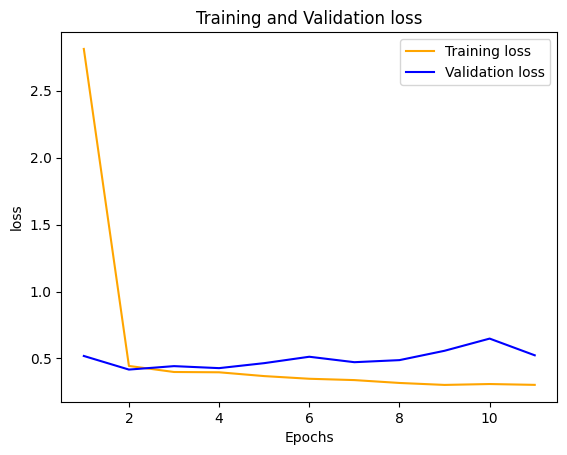

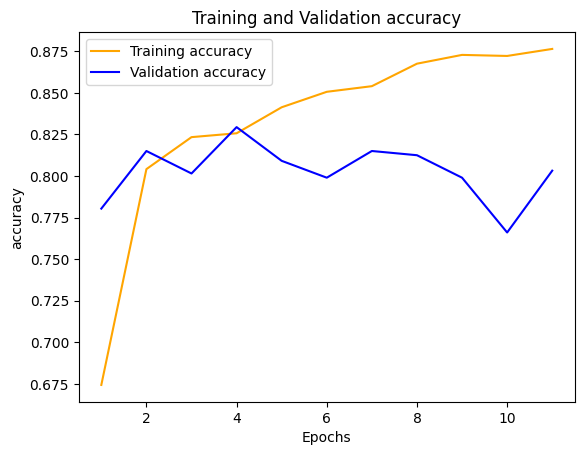

In [54]:
display_metrik(history_keempat, 'loss')
display_metrik(history_keempat, 'accuracy')

# Model 5 (CNN)
## CNN + BatchNormalization

In [ ]:
def model_5():
    model= Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=[image_sizee,image_sizee,image_channell], padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense (32, activation='relu'))
    model.add(Dropout(0.1)) # biar ga overfitting
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    return model
model_kelima = model_5()
model_kelima.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_11 (Bat  (None, 42, 42, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [59]:
history_kelima = model_kelima.fit(train_data,
                                    epochs=30,
                                    validation_data=test_data,
                                    verbose=1,
                                    callbacks=[cp_callback, lr_reduce, early_stopping], 
                                    batch_size=batch_sizee)
test_loss, test_acc = model_kelima.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/30
74/74 [==============================] - 32s 426ms/step - loss: 0.5359 - accuracy: 0.7412 - val_loss: 0.7345 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - 34s 464ms/step - loss: 0.3979 - accuracy: 0.8301 - val_loss: 0.6218 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - 37s 506ms/step - loss: 0.3429 - accuracy: 0.8557 - val_loss: 0.8939 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 4/30
74/74 [==============================] - 33s 447ms/step - loss: 0.2960 - accuracy: 0.8832 - val_loss: 0.6176 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/30
74/74 [==============================] - 34s 453ms/step - loss: 0.2871 - accuracy: 0.8827 - val_loss: 1.1333 - val_accuracy: 0.5448 - lr: 0.0010
Epoch 6/30
74/74 [==============================] - 32s 432ms/step - loss: 0.2568 - accuracy: 0.8916 - val_loss: 0.5131 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 7/30
74/74 [==============================] - 28s 379ms/st

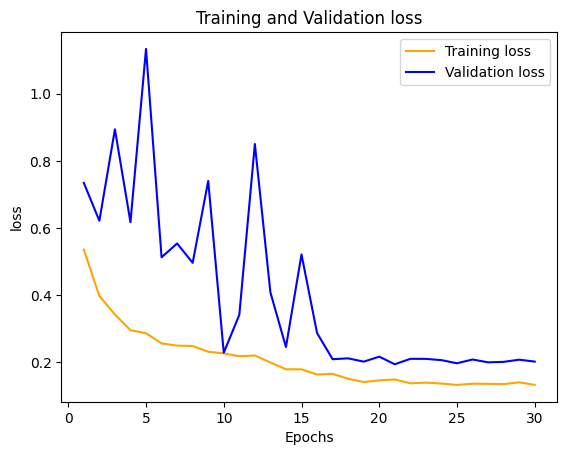

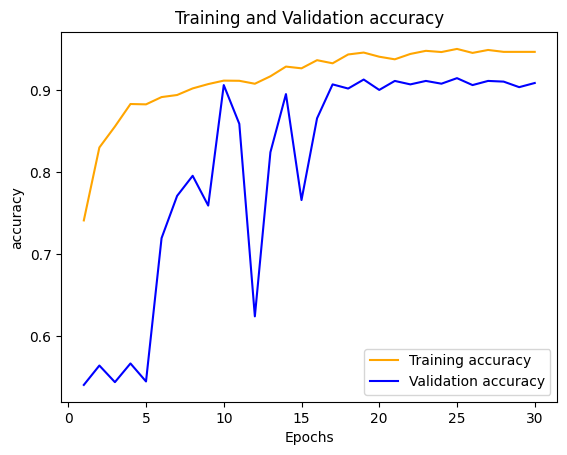

In [60]:
display_metrik(history_kelima, 'loss')
display_metrik(history_kelima, 'accuracy')

# Model 6 (CNN)
## CNN + Dropout

In [61]:
def model_6():
    model= Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=[128,128,3]))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.01))
    model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.01))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.01))
    model.add(Flatten())
    model.add(Dense (32, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    return model
model_keenam = model_6()
model_keenam.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 42, 42, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 64)        16448     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)      

In [62]:
history_keenam = model_keenam.fit(train_data,
                                epochs=30,
                                validation_data=test_data,
                                verbose=1,
                                callbacks=[cp_callback, lr_reduce, early_stopping])
test_loss, test_acc = model_keenam.evaluate(test_data, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/30
74/74 [==============================] - 33s 444ms/step - loss: 0.5930 - accuracy: 0.6767 - val_loss: 0.5176 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 2/30
74/74 [==============================] - 32s 433ms/step - loss: 0.4937 - accuracy: 0.7682 - val_loss: 0.5331 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 3/30
74/74 [==============================] - 33s 438ms/step - loss: 0.4470 - accuracy: 0.8048 - val_loss: 0.6544 - val_accuracy: 0.7086 - lr: 0.0010
Epoch 4/30
74/74 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8092
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
74/74 [==============================] - 33s 443ms/step - loss: 0.4337 - accuracy: 0.8092 - val_loss: 0.5881 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 5/30
74/74 [==============================] - 31s 422ms/step - loss: 0.3823 - accuracy: 0.8367 - val_loss: 0.3632 - val_accuracy: 0.8530 - lr: 3.0000e-04
Epoch 6/30
74/74 [==============================] - 31s 4

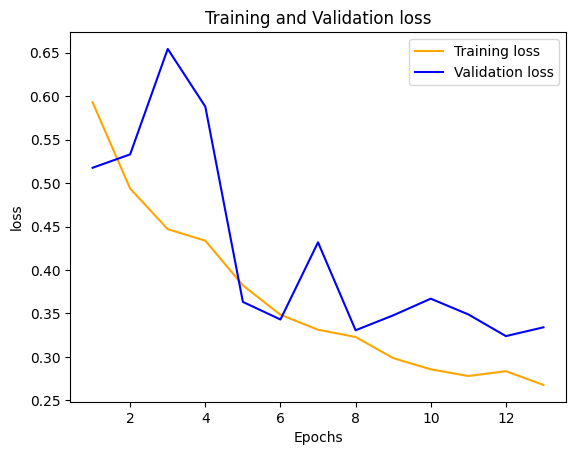

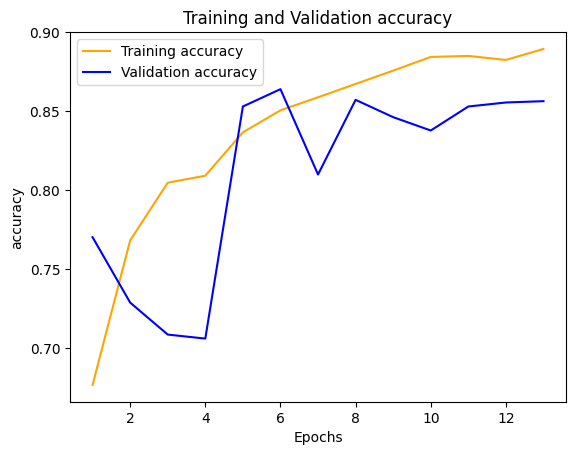

In [63]:
display_metrik(history_keenam, 'loss')
display_metrik(history_keenam, 'accuracy')

# Rekap Akurasi Model

In [99]:
test_loss, test_acc_1 = model_pertama.evaluate(test_data, verbose=2)
test_loss, test_acc_2 = model_kedua.evaluate(test_data, verbose=2)
test_loss, test_acc_3 = model_ketiga.evaluate(test_data, verbose=2)
test_loss, test_acc_4 = model_keempat.evaluate(test_data, verbose=2)
test_loss, test_acc_5 = model_kelima.evaluate(test_data, verbose=2)
test_loss, test_acc_6 = model_keenam.evaluate(test_data, verbose=2)

model_accuracies = [
    ("Model Pertama", test_acc_1, model_pertama),
    ("Model Kedua", test_acc_2, model_kedua),
    ("Model Ketiga", test_acc_3, model_ketiga),
    ("Model Keempat", test_acc_4, model_keempat),
    ("Model Kelima", test_acc_5, model_kelima),
    ("Model Keenam", test_acc_6, model_keenam)
]

sorted_accuracies = sorted(model_accuracies, key=lambda x: x[1], reverse=True)
print("\nModel\t\tAkurasi")
print("-" * 30)
for model, acc, model_tf in sorted_accuracies:
    print(f"{model}\t{acc:.2f}")

19/19 - 4s - loss: 1.2363 - accuracy: 0.4595 - 4s/epoch - 199ms/step
19/19 - 4s - loss: 0.4926 - accuracy: 0.7669 - 4s/epoch - 210ms/step
19/19 - 4s - loss: 2.2092 - accuracy: 0.5659 - 4s/epoch - 195ms/step
19/19 - 4s - loss: 0.4281 - accuracy: 0.8294 - 4s/epoch - 192ms/step
19/19 - 4s - loss: 0.2027 - accuracy: 0.9088 - 4s/epoch - 195ms/step
19/19 - 4s - loss: 0.3430 - accuracy: 0.8640 - 4s/epoch - 194ms/step

Model		Akurasi
------------------------------
Model Kelima	0.91
Model Keenam	0.86
Model Keempat	0.83
Model Kedua	0.77
Model Ketiga	0.57
Model Pertama	0.46


In [102]:
best_model = sorted_accuracies[0][2]

# Confusion Matrix

Found 1184 images belonging to 2 classes.
1184/1184 [==============================] - 5s 4ms/step


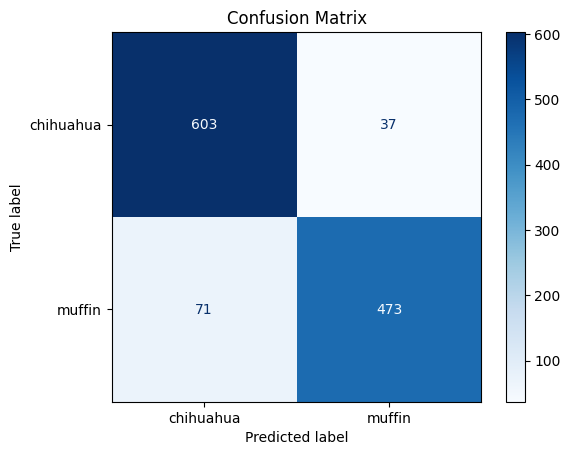

In [103]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(image_sizee, image_sizee),
                                            batch_size=1,
                                            class_mode='sparse',
                                            shuffle=False)
y_pred_prob = best_model.predict(pred_data)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = pred_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Test Data

In [79]:
test_data.class_indices

{'chihuahua': 0, 'muffin': 1}

In [80]:
label_class = {v: k for k, v in test_data.class_indices.items()}
label_class

{0: 'chihuahua', 1: 'muffin'}

1/1 [==============================] - 0s 17ms/step


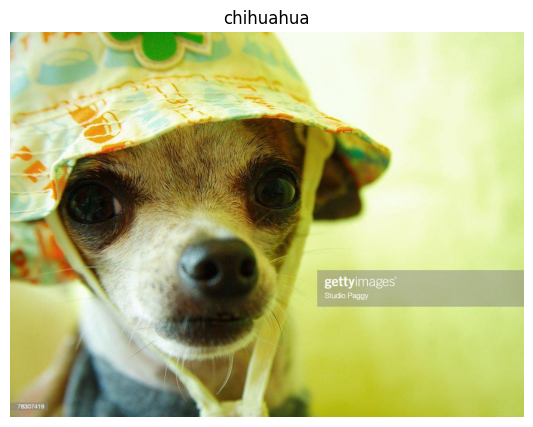

Prediksi: chihuahua
1/1 [==============================] - 0s 16ms/step


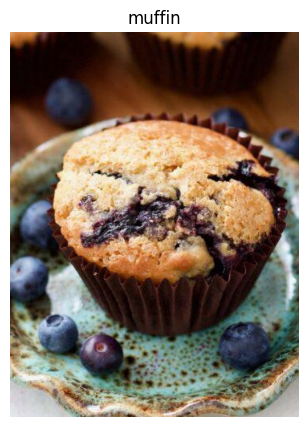

Prediksi: muffin


In [105]:
from tensorflow.keras.preprocessing import image

classes = os.listdir(test_dir)
for cls in classes:
    class_dir = os.path.join(test_dir, cls)
    images = np.random.choice(os.listdir(class_dir), 1, replace=False)
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path)
        tf_img = image.load_img(img_path, target_size=(128, 128))
        tf_img = image.img_to_array(tf_img)
        tf_img = np.expand_dims(tf_img, axis=0)
        tf_img = tf_img / 255
        pred = best_model.predict(tf_img)
        pred_class = label_class[np.argmax(pred)]
        plt.subplot(1, 1, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.show()
    print(f'Prediksi: {pred_class}')

# Export Model

In [106]:
best_model.save('model/CNN_Prak4_ML.h5')
print("Model berhasil disimpan!")

Model berhasil disimpan!


In [109]:
converter = tensorflow.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

with open('model/CNN_Prak4_ML.tflite', 'wb') as f:
    f.write(tflite_model)
    
print("Model TFLite berhasil disimpan!")

INFO:tensorflow:Assets written to: C:\Users\andik\AppData\Local\Temp\tmpw8zf8exi\assets


INFO:tensorflow:Assets written to: C:\Users\andik\AppData\Local\Temp\tmpw8zf8exi\assets


Model TFLite berhasil disimpan!


# Sekian, Terimakasih

![KCV](/assets/kcv-profile.png)